https://www.kaggle.com/moichiaaron/abell-weekly-sales-transactions-exploration

Nie ma tu wyraźnych oznak złych lub brakujących wartości. Moglibyśmy rzucić okiem na całą ramę, ponieważ to tylko 811 rzędów, ale to nie jest tak naprawdę skalowalne podejście. To, czego głównie szukamy, to wartości null, takie jak NaN itp. Pandy pozwalają nam je przeszukiwać za pomocą metody 'isnull()'.

Wygląda na to, że w tym konkretnym zestawie danych nie ma żadnych brakujących wartości. Nie oznacza to, że w danych nie ma szumu, po prostu żaden z elementów nie jest niezdefiniowany.

 - Być może będziemy musieli później wykluczyć inne punkty danych, w zależności od dokładnych celów analizy. To znaczy. co robimy z produktami, których sprzedaż jest na płasko przez cały rok?

 - Ogólne podejście

Najpierw przygotujemy przybliżoną metodę znajdowania grup produktów, które są ze sobą bardziej powiązane.
Innymi słowy, chcemy wiedzieć, które produkty mają podobne wzorce sprzedaży, nawet jeśli pochodzą z zupełnie innych kategorii. Jeśli chodzi o skalę czasową: na początek przyjrzymy się ogólnemu wzorcowi w ciągu roku, dla którego mamy dane. Potencjalnym wyzwaniem jest to, że przy tak ograniczonym zestawie danych mamy tylko jeden przykład na dzień kalendarzowy. Oddzielenie wzorców sezonowych, miesięcznych i tygodniowych od hałasu może być trudne.

 - Wybór funkcji
Po przyjrzeniu się powyższym kolumnom, widzimy, że są to liczby produktów tygodniowo, a także znormalizowana sprzedaż. Bez przyjęcia jakichkolwiek założeń dotyczących typów produktów na liście nie wiemy, czy liczenie sprzedaży na sztukę jest prawidłowym sposobem porównywania produktów. Niektóre produkty są kupowane po kilka na raz, a inne tylko po jednym na raz. Rozważymy, że ich względne różnice są ważniejsze i na razie zachowamy tylko znormalizowane kolumny.

UWAGA: Alternatywnym sposobem spojrzenia na ten problem jest myślenie o tygodniach roku jako punktach danych, a produktach jako funkcjach. Być może będziemy musieli spróbować później.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
data = pd.read_csv('/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


Oddziel funkcje wejściowe od celu. Zauważ, że cel znajduje się w pierwszej kolumnie pliku CSV. Przekształć wartości na tensory, upewniając się, że są konwertowane na zmiennoprzecinkowe:

In [3]:
data.describe()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
count,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,...,811.000000,811.000000,811.000000,811.000000,811.000000,811.000000,811.00000,811.000000,811.000000,811.000000
mean,8.902589,9.129470,9.389642,9.717633,9.574599,9.466091,9.720099,9.585697,9.784217,9.681874,...,0.299149,0.287571,0.304846,0.316017,0.334760,0.314636,0.33815,0.358903,0.373009,0.427941
std,12.067163,12.564766,13.045073,13.553294,13.095765,12.823195,13.347375,13.049138,13.550237,13.137916,...,0.266993,0.256630,0.263396,0.262226,0.275203,0.266029,0.27569,0.286665,0.295197,0.342360
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.020000,0.085000,0.000000,0.10500,0.100000,0.110000,0.090000
50%,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,...,0.280000,0.270000,0.300000,0.310000,0.330000,0.310000,0.33000,0.330000,0.350000,0.430000
75%,12.000000,12.000000,12.000000,13.000000,13.000000,12.500000,13.000000,12.500000,13.000000,13.000000,...,0.490000,0.450000,0.500000,0.500000,0.500000,0.500000,0.50000,0.550000,0.560000,0.670000
max,54.000000,53.000000,56.000000,59.000000,61.000000,52.000000,56.000000,62.000000,63.000000,52.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


Tygodniowe różnice w sprzedaży („szybkości”)
Aby zrozumieć, że produkty są ze sobą powiązane, prawdopodobnie chcemy wiedzieć, czy ich sprzedaż zmienia się z tygodnia na tydzień. Aby podejść do tego pytania, pomocne może być obliczenie „prędkości sprzedaży” lub macierz różnic pokazująca, jak bardzo sprzedaż wzrosła lub spadła w każdym tygodniu. Zakłada się, że produkty o podobnych wahaniach sprzedaży są podobne i powinny być uzupełniane mniej więcej w tym samym czasie.

UWAGA: W rzeczywistości powinno to podlegać ograniczeniom dotyczącym wielkości i częstotliwości zamówienia uzupełnienia zapasów.

In [4]:
data.isnull().values.any()

False

In [5]:
data_norm = data.copy()

data_norm[['Normalized {}'.format(i) for i in range(0,52)]].head()

,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,0.44,0.50,0.39,0.28,0.56,0.50,0.61,1.00,0.17,0.61,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,0.70,0.60,0.30,0.20,0.70,0.10,0.60,0.30,0.30,0.30,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,0.36,0.73,0.45,0.55,0.64,0.45,0.36,0.91,0.82,0.27,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,0.59,0.35,0.65,0.18,0.41,0.24,0.41,0.65,0.65,0.53,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,0.33,0.13,0.67,0.53,0.20,0.27,0.40,0.73,0.40,0.40,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [6]:
data_norm = data_norm[['Normalized {}'.format(i) for i in range(0,52)]]
data_norm.head()

,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,0.44,0.50,0.39,0.28,0.56,0.50,0.61,1.00,0.17,0.61,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,0.70,0.60,0.30,0.20,0.70,0.10,0.60,0.30,0.30,0.30,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,0.36,0.73,0.45,0.55,0.64,0.45,0.36,0.91,0.82,0.27,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,0.59,0.35,0.65,0.18,0.41,0.24,0.41,0.65,0.65,0.53,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,0.33,0.13,0.67,0.53,0.20,0.27,0.40,0.73,0.40,0.40,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [7]:
data_norm.diff(axis=1).head()

,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,NaN,0.06,-0.11,-0.11,0.28,-0.06,0.11,0.39,-0.83,0.44,...,-0.38,0.16,0.06,0.11,0.11,-0.50,0.22,-0.05,-0.06,0.28
1,NaN,-0.10,-0.30,-0.10,0.50,-0.60,0.50,-0.30,0.00,0.00,...,-0.30,0.20,0.10,-0.40,0.00,0.30,0.10,-0.40,0.50,-0.60
2,NaN,0.37,-0.28,0.10,0.09,-0.19,-0.09,0.55,-0.09,-0.55,...,0.09,0.73,-0.82,0.00,0.18,0.09,0.55,-0.55,0.00,-0.09
3,NaN,-0.24,0.30,-0.47,0.23,-0.17,0.17,0.24,0.00,-0.12,...,0.17,0.06,-0.41,0.06,0.12,0.11,0.36,-0.36,-0.06,0.06
4,NaN,-0.20,0.54,-0.14,-0.33,0.07,0.13,0.33,-0.33,0.00,...,-0.06,0.26,-0.26,0.33,-0.40,0.00,-0.07,0.40,-0.20,0.07


In [43]:
data_norm_diff = data_norm.diff(axis=1).drop('Normalized 0', axis=1).copy()
data_norm_diff.head()

,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,Normalized 10,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,0.06,-0.11,-0.11,0.28,-0.06,0.11,0.39,-0.83,0.44,-0.17,...,-0.38,0.16,0.06,0.11,0.11,-0.50,0.22,-0.05,-0.06,0.28
1,-0.10,-0.30,-0.10,0.50,-0.60,0.50,-0.30,0.00,0.00,-0.10,...,-0.30,0.20,0.10,-0.40,0.00,0.30,0.10,-0.40,0.50,-0.60
2,0.37,-0.28,0.10,0.09,-0.19,-0.09,0.55,-0.09,-0.55,0.73,...,0.09,0.73,-0.82,0.00,0.18,0.09,0.55,-0.55,0.00,-0.09
3,-0.24,0.30,-0.47,0.23,-0.17,0.17,0.24,0.00,-0.12,-0.18,...,0.17,0.06,-0.41,0.06,0.12,0.11,0.36,-0.36,-0.06,0.06
4,-0.20,0.54,-0.14,-0.33,0.07,0.13,0.33,-0.33,0.00,0.13,...,-0.06,0.26,-0.26,0.33,-0.40,0.00,-0.07,0.40,-0.20,0.07


Przykładowy test pokrewieństwa dla Produktu 1
Po zapoznaniu się z różnicami dla wszystkich produktów w ciągu całego roku, możemy teraz co tydzień zobaczyć, jak każdy produkt różnił się od pozostałych.

In [11]:
data_norm_diff_prod1 =  data_norm_diff.values - data_norm_diff.values[0,:]
data_norm_diff_prod1

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-0.16, -0.19,  0.01, ..., -0.35,  0.56, -0.88],
       [ 0.31, -0.17,  0.21, ..., -0.5 ,  0.06, -0.37],
       ...,
       [-0.31,  0.11,  0.11, ...,  0.05,  1.06, -0.53],
       [-0.06,  0.11,  0.61, ...,  0.05,  1.06, -1.28],
       [ 0.27, -0.22,  0.11, ...,  0.05,  0.06,  0.05]])

In [12]:
data_norm_diff_prod1_sum = (data_norm_diff_prod1**2).sum(axis=1)
data_norm_diff_prod1_sum.shape

(811,)

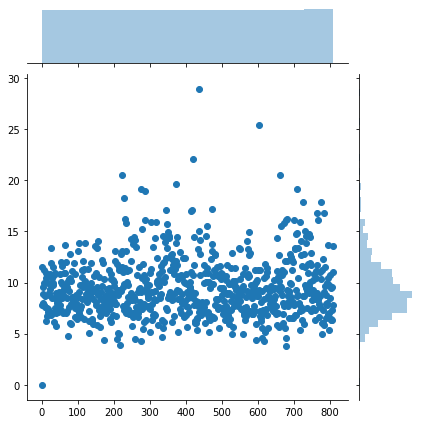

In [13]:
import seaborn as sb
sb.jointplot(x = np.arange(0,811,1), 
             y = data_norm_diff_prod1_sum,
            kind='scatter')
#plt.scatter(range(0,811),data_norm_diff_prod1_sum)

In [14]:
prod1_velocities = pd.DataFrame(data_norm_diff_prod1_sum**2, columns=["Vel_total_diff"])

In [15]:
prod1_velocities.sort_values(by="Vel_total_diff")

,Vel_total_diff
0,0.000000
677,14.628330
217,15.013300
618,18.251693
275,18.703030
...,...
224,420.442722
662,420.442722
420,487.733974
604,646.415370


In [16]:
def getWeeklyDiffs(products_sales_table):
    
    return products_sales_table.diff(axis=1).drop(products_sales_table.columns[0], axis=1).copy()

def getProductErrors(product_index, products_diffs):
    
    return products_diffs - products_diffs.iloc[product_index]
    
def getTotalSquaredError(per_product_error):
    
    return pd.DataFrame((per_product_error**2).sum(axis=1), columns=["Total Error"])
    
def makeProductVelErrorMatrix(products_diffs, nproducts):
    
    product_error_matrix = pd.DataFrame()
    
    for i in range(0,nproducts):
    
        product_errors_table = getProductErrors(i, product_diffs)
        
        product_errors_sumsq = getTotalSquaredError(product_errors_table)
        
        product_error_matrix[i] = product_errors_sumsq
        
    return product_error_matrix
        
        

In [17]:
product_diffs  = getWeeklyDiffs(data_norm)
product_diffs

,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,Normalized 10,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,0.06,-0.11,-0.11,0.28,-0.06,0.11,0.39,-0.83,0.44,-0.17,...,-0.38,0.16,0.06,0.11,0.11,-0.50,0.22,-0.05,-0.06,0.28
1,-0.10,-0.30,-0.10,0.50,-0.60,0.50,-0.30,0.00,0.00,-0.10,...,-0.30,0.20,0.10,-0.40,0.00,0.30,0.10,-0.40,0.50,-0.60
2,0.37,-0.28,0.10,0.09,-0.19,-0.09,0.55,-0.09,-0.55,0.73,...,0.09,0.73,-0.82,0.00,0.18,0.09,0.55,-0.55,0.00,-0.09
3,-0.24,0.30,-0.47,0.23,-0.17,0.17,0.24,0.00,-0.12,-0.18,...,0.17,0.06,-0.41,0.06,0.12,0.11,0.36,-0.36,-0.06,0.06
4,-0.20,0.54,-0.14,-0.33,0.07,0.13,0.33,-0.33,0.00,0.13,...,-0.06,0.26,-0.26,0.33,-0.40,0.00,-0.07,0.40,-0.20,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,0.00,0.33,-0.33,0.00,0.67,-0.34,-0.33,0.00,0.33,-0.33,...,0.00,0.33,0.00,-0.33,0.00,0.33,-0.33,0.00,0.67,-0.67
807,0.14,-0.14,0.00,0.14,0.15,0.00,0.57,-0.86,0.14,-0.14,...,-0.57,0.00,0.14,-0.28,0.28,0.14,0.00,0.00,0.15,-0.15
808,-0.25,0.00,0.00,0.25,0.00,0.25,-0.25,0.00,-0.25,0.00,...,0.25,-0.50,0.00,0.50,0.00,-0.50,0.00,0.00,1.00,-0.25
809,0.00,0.00,0.50,-0.50,0.00,0.00,0.00,0.50,-0.50,0.00,...,0.00,0.00,0.00,0.50,0.00,-0.50,0.00,0.00,1.00,-1.00


In [20]:
#error_matrix = makeProductVelErrorMatrix(product_diffs, 811)

In [21]:
def getTotalSquaredError(per_product_error, signed = True):
    
    if signed == False:
        return pd.DataFrame((per_product_error**2).sum(axis=1), columns=["Total Error"])
    else:
        return pd.DataFrame((per_product_error).sum(axis=1)**2, columns=["Total Error"])


# Experiment with PCA

Teraz, gdy już zaspokoiłem ciekawość, czas przetestować bardziej konwencjonalne podejście.

PCA jest często używany do odwzorowywania/kompresji danych, dzięki czemu można je łatwo zwizualizować. Pomysł polega na znalezieniu wektorów własnych macierzy kowariancji --- jeśli uporządkujemy te wektory według ich wartości własnych, mamy nadzieję znaleźć zbiór dogodnych wektorów głównych. Możesz myśleć o tym, że ma znajdowanie stałych „szablonów”, które wyjaśniają typowe trendy w Twoich danych. Jednak działa to dobrze tylko wtedy, gdy istnieje pewna nadmiarowość wśród twoich funkcji. Powszechną praktyką jest próba zredukowania wymiarowości do 3 lub 2 w celu łatwej wizualizacji. Są jednak przypadki, w których nie ma to sensu, na przykład gdy pierwsze 2 lub 3 składniki nie wyjaśniają dużej części wariancji danych.

Zrobimy szybki test, kompresując jak najwięcej wariancji na 2 składniki.

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=3)

In [26]:
pca_data_norm = PCA(n_components=2)

In [27]:
pca_data_norm.fit_transform(data_norm.T)

array([[-1.5680362 , -0.09911094],
       [-1.93723134, -0.01993398],
       [-1.90565454,  0.11358775],
       [-2.26158226,  0.71803661],
       [-1.64810571,  0.70011026],
       [-1.5607012 ,  0.70848738],
       [-2.15236414,  0.78257385],
       [-1.84756212,  0.79175789],
       [-2.02565511,  0.99990531],
       [-1.97942986,  0.95557958],
       [-2.49904041,  1.13115699],
       [-2.007435  ,  0.98522909],
       [-1.64449161,  1.18775011],
       [-1.83835805,  1.03828774],
       [-1.23679908,  1.38712336],
       [-1.86571404,  1.91017747],
       [-2.10078729,  1.36089149],
       [-1.6397456 ,  2.01964644],
       [-1.40139131,  1.79549356],
       [-1.27157631,  1.58603883],
       [-1.46817096,  1.5404447 ],
       [-0.37034299,  1.88637447],
       [-0.17810634,  2.18347962],
       [ 0.46820174,  3.00443099],
       [ 2.28708455,  4.45462242],
       [ 5.00740301,  3.06611951],
       [ 0.59011338, -3.38586159],
       [ 0.44827834, -3.2369514 ],
       [ 0.20095579,

In [28]:
print(pca_data_norm.explained_variance_ratio_)
print(pca_data_norm.explained_variance_ratio_.sum())


[0.08654291 0.07679723]
0.1633401335253413


Jak dotąd trudność polega na tym, że PCA nie jest w stanie wcisnąć dużej wariancji tylko do 2 składników, a nawet 3. To problem, ponieważ 3 to najwięcej, co możemy wykreślić zwykli śmiertelnicy.

Jeśli przyjrzymy się stosunkowi wariancji dla pierwszego komponentu, 8,65% --- oznacza to, że nawet jeśli nie uzyskamy zadowalającej redukcji czystych wymiarów, nadal możemy osiągnąć lepsze wyniki niż 811 wymiarów. Przejdźmy do szybkiego testu, aby zobaczyć, ile składników potrzebujemy, aby wyjaśnić arbitralne 90% wariancji:

At least 42 components needed to explain 90.0% of the variance.


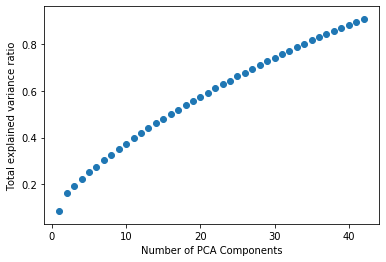

In [29]:
def determineNComponents(data, variance_threshold=0.90):
    
    n_components = 0
    sum_explained_variance = 0
    sum_list = []
    
    while sum_explained_variance < variance_threshold:
        n_components += 1
        pca_data_norm = PCA(n_components=n_components)
        pca_data_norm.fit_transform(data)
        sum_explained_variance = pca_data_norm.explained_variance_ratio_.sum()
        
        sum_list.append(sum_explained_variance)
        
    plt.scatter(np.arange(1,n_components+1,1),
               sum_list)
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Total explained variance ratio")
    
    print("At least {} components needed to explain {}% of the variance.".format(n_components,variance_threshold*100))
                
    return n_components

min_components  = determineNComponents(data_norm.T)

Możemy skompresować nasze dane z 811 do 42 wymiarów i nadal wyjaśniać 99% wariancji. Gdybyśmy byli nierozważnie nastawieni na uruchamianie i uruchamianie szybkiego modelu roboczego K-średnich, moglibyśmy użyć tej liczby jako wstępnego przypuszczenia liczby klastrów K-średnich. Chodźmy dalej i spróbujmy.

Najpierw uruchom ponownie PCA z optymalną liczbą komponentów, które właśnie ustaliliśmy. Następnie uruchom K-średnie na wykresie punktowym pierwszych dwóch składników PCA.

In [30]:
pca_data_norm.fit_transform(data_norm.T)

array([[-1.56804267, -0.09896985],
       [-1.93721767, -0.01995895],
       [-1.90566033,  0.11377742],
       [-2.2615907 ,  0.71799261],
       [-1.64808383,  0.70001388],
       [-1.5607428 ,  0.70866022],
       [-2.15242484,  0.78267662],
       [-1.84758524,  0.79173477],
       [-2.02561986,  0.99974523],
       [-1.97936949,  0.95578645],
       [-2.49905009,  1.13105476],
       [-2.00750991,  0.98544884],
       [-1.64449539,  1.1878922 ],
       [-1.83832614,  1.03863468],
       [-1.23682684,  1.38726136],
       [-1.86571951,  1.91025196],
       [-2.10079205,  1.36095713],
       [-1.6397361 ,  2.0194272 ],
       [-1.40133346,  1.79528582],
       [-1.27164815,  1.58591305],
       [-1.46811863,  1.54025733],
       [-0.37028586,  1.88630477],
       [-0.17812674,  2.18317199],
       [ 0.46813845,  3.00453813],
       [ 2.28722358,  4.45422039],
       [ 5.00734007,  3.06628269],
       [ 0.59014686, -3.38594594],
       [ 0.44833008, -3.23697171],
       [ 0.2010048 ,

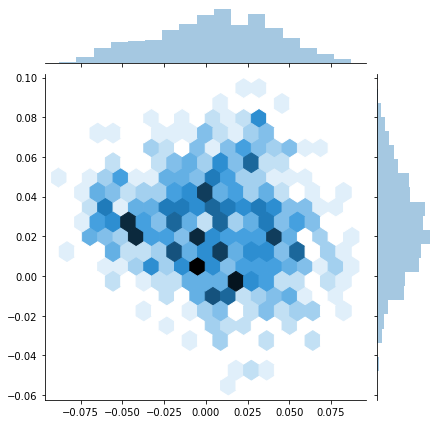

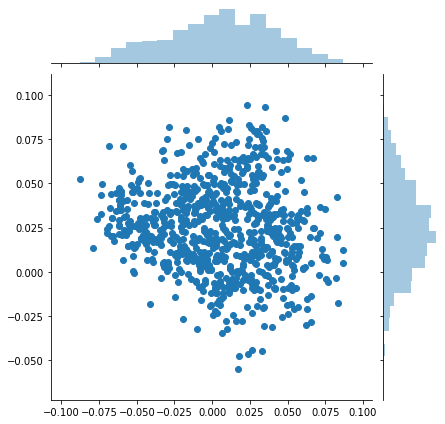

In [31]:
sb.jointplot(x=pca_data_norm.components_[0,:], 
             y=pca_data_norm.components_[1,:],
            kind='hex')
sb.jointplot(x=pca_data_norm.components_[0,:], 
             y=pca_data_norm.components_[1,:],
            kind='scatter')

In [32]:
components_data_norm = pca_data_norm.components_

In [33]:
from sklearn.cluster import KMeans 

In [34]:
kmeans = KMeans(n_clusters=min_components)  
kmeans.fit(data_norm)  

KMeans(n_clusters=42)

In [35]:
print(kmeans.cluster_centers_) 

[[0.06666667 0.17666667 0.11       ... 0.34333333 0.06666667 0.69      ]
 [0.434      0.38333333 0.49433333 ... 0.31766667 0.268      0.15166667]
 [0.385      0.40666667 0.32666667 ... 0.54462963 0.61555556 0.78166667]
 ...
 [0.699      0.657      0.801      ... 0.453      0.352      0.247     ]
 [0.24714286 0.30142857 0.45571429 ... 0.36       0.23857143 0.42642857]
 [0.25454545 0.26454545 0.26454545 ... 0.91363636 0.33454545 0.70909091]]


Text(0.5, 0, '2nd Princiapl Component')

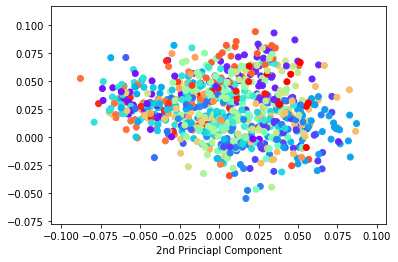

In [36]:
plt.scatter(x= components_data_norm[0,:],
            y= components_data_norm[1,:],
            c=kmeans.labels_, 
            cmap='rainbow') 

plt.xlabel("1st Princiapl Component")
plt.xlabel("2nd Princiapl Component")

Żadna z dotychczas stosowanych technik nie daje nam pożądanego stopnia skupienia się wśród dumnych. Chociaż k-means chętnie przypisuje dla nas produkty do klastrów, wyniki często mogą być bezsensowne.

Nie żeby to było zaskakujące. Wiemy już, że tylko 2 składniki PCA to za mało. Tak więc, nawet jeśli grupowanie k-średnich działało dobrze, taki wykres punktowy PCA może nie pokazywać tak dużo.

Uzyskanie użytecznego wyniku sprowadzam się do techniki redukcji wymiarowości, niekoniecznie techniki grupowania. Można również wypróbować inne techniki reprojekcji, takie jak „Analiza niezależnych składowych” (ICA), „Non-negative Matrix Factorization” (NMF), „t-Distributed Stochastic Neighbor Embedding” (t-SNE), ale nic nie wskazuje na to, by były działają lepiej niż PCA w tym przypadku. W moim rozumieniu ICA w rzeczywistości nie zmniejsza wymiarowości, a raczej maksymalizuje niezależność między wymiarami.

W ostatnim eksperymencie zrobię krótkie demo tego, jak można zastosować TSNE. Główną wadą TSNE jest jednak to, że trudniej jest wyjaśnić fizyczne znaczenie kryjące się za danymi wyjściowymi.

In [37]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

In [38]:
components_tsne = tsne.fit_transform(data_norm)

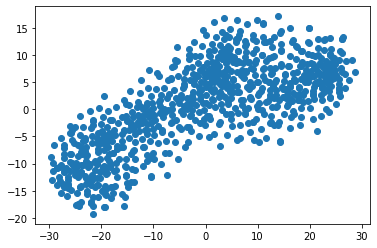

In [39]:
plt.scatter(x= components_tsne[:,0],
            y= components_tsne[:,1],
            cmap='rainbow') 

Przynajmniej subiektywnie wygląda na to, że w tej projekcji 2D TSNE zachowano więcej struktury niż w dwóch najwyższych wymiarach PCA. (Musimy jednak być ostrożni, ponieważ tSNE może czasami wywoływać sztuczną strukturę.) Zróbmy grupowanie k-średnich, przyjmując raczej pospieszne n-zgrupowań po 3, tylko przez inspekcję wzrokową.

In [40]:
kmeans_tsne = KMeans(n_clusters=3, random_state=42)  
kmeans_tsne.fit(data_norm)

KMeans(n_clusters=3, random_state=42)

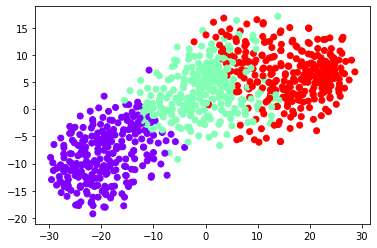

In [41]:
plt.scatter(x    = components_tsne[:,0],
            y    = components_tsne[:,1],
            cmap = 'rainbow',
            c    = kmeans_tsne.labels_)

Wybory skupień tutaj wydają się rozsądne, ale co, jeśli wybierzemy 42 skupienia (po naszym wyjaśnionym teście wariancji PCA), jak poprzednio?

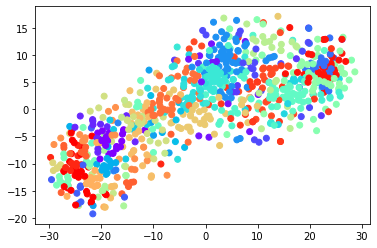

In [42]:
kmeans_tsne = KMeans(n_clusters=42, random_state=42)  
kmeans_tsne.fit(data_norm)  

plt.scatter(x    = components_tsne[:,0],
            y    = components_tsne[:,1],
            cmap = 'rainbow',
            c    = kmeans_tsne.labels_) 

Znowu mamy trochę bałaganu. Trudno powiedzieć, czy projekcja tSNE czy PCA lepiej odzwierciedla przypisania do klastrów. Do niezależnej walidacji należałoby stwierdzenie, czy te wybory klastrowe są realistyczne. Może porównanie z rzeczywistymi kategoriami produktów przypisanymi przez człowieka? (Prawdopodobnie takie dane są dostępne...) Alternatywnie klastry można wykorzystać do informowania o hipotetycznych zamówieniach na uzupełnienie zapasów na nadchodzące tygodnie lub miesiące. Można by wtedy zapytać, jaki wpływ na koszty miałaby taka strategia sprzedaży wiązanej.

Oczywiście moglibyśmy zrobić taki test z obecnymi danymi: klaster na jednej połowie, test na drugiej połowie, ale to może okazać się trudne. Dowolny podzbiór obecnych danych (1 rok kalendarzowy) kazałby nam trenować i testować w różnych porach roku. Pożądane jest więcej danych... co najmniej dwa lata kalendarzowe.

Wnioski:
 - Możliwe jest pogrupowanie produktów na podstawie zmiany ich sprzedaży netto w ciągu roku.
 - Ten konkretny zbiór danych wydaje się trudny do skompresowania do czytelnej dla człowieka liczby wymiarów
 - PCA wskazuje, że potrzebujemy co najmniej 42 wymiarów, aby wyjaśnić 90% całkowitej wariancji
 - Zastosowanie k-średnich (z 4 skupieniami) na górnych 2 wymiarach PCA daje bardzo zachodzące na siebie skupienia.
 - Zmniejszenie wymiarowości do 2 za pomocą t-SNE z pewnością daje fabułę o bardziej widocznej strukturze, ale trudno jest określić, czy jest to prawdziwe, to artefakt tSNE.


Możliwe przyszłe prace:
 - Przetestuj wyniki grupowania K-średnich przez eksperyment: Użyj przypisanych klastrów, aby złożyć zamówienia na wirtualne uzupełnianie zapasów w nadchodzącym roku. Oceń, jak takie zamówienia wpłynęłyby na wynik finansowy, gdyby zostały zrealizowane.
 - Podejdź do problemu najpierw jako do problemu prognozowania sprzedaży - może wykorzystaj pierwszą połowę roku do szkolenia, a drugiego kwartału do testowania itp.
 - Byłoby wspaniale mieć więcej niż jeden rok danych! Trudne do modelowania zmian sezonowych z tylko jednym przykładem na tydzień kalendarzowy.
 - Każda z zastosowanych tutaj metod, nawet bardzo dobrze wdrożona, będzie musiała zostać znacznie dopracowana zgodnie z rzeczywistymi kryteriami uzupełniania zapasów: okresem, wolumenem, limitami cenowymi itp.
 - Spróbuj kategoryzować według tygodni, a nie według pozycji: tygodnie klastrowe z podobnymi profilami sprzedaży, a następnie odzyskaj najlepiej sprzedające się pozycje dla tych klastrów. Te najlepiej sprzedające się produkty można zintegrować ze strategią uzupełniania zapasów na te tygodnie kalendarzowe. (Ale znowu wracamy do ograniczenia zakresu danych).